In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch 
from transformers import pipeline, CamembertTokenizer, CamembertModel, CamembertForSequenceClassification, AdamW

/home/rockl33/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
df = pd.read_csv("french_tweets.csv")
df = df.sample(frac=1)
df.head()

,label,text
956022,1,Dieu a mis comme ici et par la foi il y aura d...
940417,1,Hey whatsup certifié toxicomane restaurant ville?
584286,0,"Occupé, occupé ... manquez mon co-travail"
263206,0,"Nouvelle publication de blog: désolé, aucune l..."
595249,0,Hahah that's awesome !!! Enfin quelqu'un aime ...


In [3]:
model_name = "camembert-base"
model = CamembertForSequenceClassification.from_pretrained(model_name)
tokenizer = CamembertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.weight'

In [6]:
pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [7]:
sample_tweets = df.sample(10)["text"].tolist()
pipe(sample_tweets)

[{'label': 'LABEL_1', 'score': 0.5151234269142151},
 {'label': 'LABEL_1', 'score': 0.5166407823562622},
 {'label': 'LABEL_1', 'score': 0.521996021270752},
 {'label': 'LABEL_1', 'score': 0.5122599005699158},
 {'label': 'LABEL_1', 'score': 0.5149708390235901},
 {'label': 'LABEL_1', 'score': 0.5147616267204285},
 {'label': 'LABEL_1', 'score': 0.5148693323135376},
 {'label': 'LABEL_1', 'score': 0.5204548835754395},
 {'label': 'LABEL_1', 'score': 0.5188602805137634},
 {'label': 'LABEL_1', 'score': 0.5192782282829285}]

> The model is obviously not trained yet, since all its prediction scores are 0.5

# TRAINING

In [6]:
train_size = 0.7
batch_size = 16
n_iter = 10

n,_ = df.shape
df_train = df.iloc[:int(train_size*n)]
df_test = df.iloc[int(train_size*n):]

optimizer = AdamW(model.parameters(), lr=1e-5)

In [7]:
loss_values = []

for e in range(n_iter):
    df_batch = df_train.sample(batch_size)
    text_batch = df_batch["text"].tolist()
    encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    labels = torch.tensor(df_batch["label"].tolist()).unsqueeze(0)
    
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    loss_values.append(loss.item())
    print(f"===> Iteration {e}: {loss.item()}")

===> Iteration 0: 0.703162670135498
===> Iteration 1: 0.6960020065307617
===> Iteration 2: 0.690544068813324
===> Iteration 3: 0.6940597295761108
===> Iteration 4: 0.6898472905158997
===> Iteration 5: 0.6952105164527893
===> Iteration 6: 0.6965254545211792
===> Iteration 7: 0.6933307647705078
===> Iteration 8: 0.684251070022583
===> Iteration 9: 0.6983571648597717


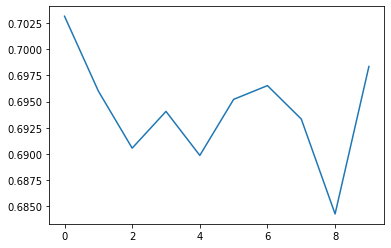

In [8]:
plt.plot(loss_values)
plt.show()

# TESTING

In [14]:
n_sample_test = 30

df_sample_test = df_test.sample(n_sample_test)
text_batch = df_sample_test["text"].tolist()
encoding = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
labels = torch.tensor(df_sample_test["label"].tolist()).unsqueeze(0)

outputs = model(input_ids, attention_mask=attention_mask)
logits = outputs.logits

In [15]:
def print_accuracy(predictions, labels):
    accuracy = 1 - np.mean(np.abs(predictions - labels))
    print(f"Accuracy: {accuracy}")

In [16]:
predictions = np.argmax(logits.detach().numpy(), axis=1)
print_accuracy(predictions, labels.detach().numpy())

Accuracy: 0.5666666666666667
